# Hackaton BBVA - Reto Retargeting - BigMinds Team

## Carga y descripción estadística del dataset

In [1]:
import pandas as pd

In [2]:
!pip install fsspec
!pip install gcsfs

In [3]:
dataset = pd.read_csv('gs://bbva-hackaton-bigminds/application_record_(experimentation).csv', header=0)
dataset.drop(columns=["ID"], inplace=True)

In [4]:
dataset.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
dataset.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


## Generación de valores para el target para el dataset

Considerando que el dataset utilizado no cuenta con valores para el target y que la tasa de conversión del canal de retargeting actual (call-center) es de 5.75%, se procederá a generar dichos valores para formar un dataset desbalanceado con un ratio 94(0):6(1), que represente la tasa de conversión anteriormente mencionada, donde "0" representa a los clientes que pasaron la evaluación de riesgo pero que no terminaron con el proceso hasta la activación de la tarjeta de crédito mediante el canal de retargeting actual, y "1" representa a los que sí terminaron con el proceso.

In [6]:
from sklearn.datasets import make_classification
from collections import Counter

In [7]:
X_gen, y_gen = make_classification(n_samples=438557, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.94], flip_y=0, random_state=1)

In [8]:
counter = Counter(y_gen)
print(counter)

Counter({0: 412244, 1: 26313})


## Formación de los subsets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
y= y_gen.copy()
X= dataset

### Se separa una porción para cargarlo por la página web

In [128]:
X_exp, X_testing_webpage, y_exp, y_testing_webpage = train_test_split(X, y, stratify=y, test_size=0.0001, random_state=1)

### Se forman los subsets de entrenamiento y prueba

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_exp, stratify=y_exp, test_size=0.2, random_state=1)

## Preprocesamiento de los Datos

### Verificacion de valores faltantes

In [13]:
cols = X_train.isna().sum()
print(cols)

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        107215
CNT_FAM_MEMBERS             0
dtype: int64


### Se eliminan las características con muchos valores faltantes

In [14]:
columnas_eliminadas = X_train.columns[X_train.isnull().mean() >= 0.3].tolist()
X_train.drop(columns = columnas_eliminadas, inplace = True)
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
297872,F,N,Y,0,270000.0,Commercial associate,Higher education,Married,House / apartment,-11564,-1985,1,0,0,0,2.0
24457,F,Y,Y,0,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-17330,-962,1,0,1,0,2.0
356993,F,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-19396,-1296,1,0,1,0,2.0
356889,M,Y,N,0,225000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21156,365243,1,0,0,0,2.0
417768,M,Y,Y,1,247500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15793,-923,1,0,0,0,3.0


In [15]:
print(columnas_eliminadas)

['OCCUPATION_TYPE']


### Imputación de datos

In [16]:
import numpy as np
import statistics as st
from pprint import pprint

In [17]:
X_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS'],
      dtype='object')

#### Se utiliza a la media para las características numéricas

In [18]:
lst_caract_num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

medias_dict = {}
for columna in lst_caract_num:
    media_caract = X_train[columna].astype("float").mean(axis=0)
    medias_dict[columna] = media_caract
    X_train[columna].replace(np.nan, media_caract, inplace=True)
    
pprint(medias_dict)

{'AMT_INCOME_TOTAL': 187556.07102886462,
 'CNT_CHILDREN': 0.4279039270187442,
 'CNT_FAM_MEMBERS': 2.1949340745492125,
 'DAYS_BIRTH': -15998.155472881477,
 'DAYS_EMPLOYED': 60464.453735300405}


#### Se utiliza a la moda para las características categóricas

In [19]:
lst_caract_categ = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL'
]

modas_dict = {}
for columna in lst_caract_categ:
    moda_caract = st.mode(X_train[columna])
    modas_dict[columna] = moda_caract
    X_train[columna].replace(np.nan, moda_caract, inplace=True)

pprint(modas_dict)

{'CODE_GENDER': 'F',
 'FLAG_EMAIL': 0,
 'FLAG_MOBIL': 1,
 'FLAG_OWN_CAR': 'N',
 'FLAG_OWN_REALTY': 'Y',
 'FLAG_PHONE': 0,
 'FLAG_WORK_PHONE': 0,
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'NAME_INCOME_TYPE': 'Working'}


In [20]:
cols = X_train.isna().sum()
print(cols)

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
CNT_FAM_MEMBERS        0
dtype: int64


### Corrección de los tipos de datos de las características

In [21]:
X_train.dtypes

CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
CNT_FAM_MEMBERS        float64
dtype: object

In [22]:
for columna in lst_caract_categ:
    X_train[columna] = X_train[columna].astype('category')

In [23]:
X_train.dtypes

CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
NAME_INCOME_TYPE       category
NAME_EDUCATION_TYPE    category
NAME_FAMILY_STATUS     category
NAME_HOUSING_TYPE      category
DAYS_BIRTH                int64
DAYS_EMPLOYED             int64
FLAG_MOBIL             category
FLAG_WORK_PHONE        category
FLAG_PHONE             category
FLAG_EMAIL             category
CNT_FAM_MEMBERS         float64
dtype: object

### Selección de características

In [24]:
!pip install seaborn

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#### Agrupación de características numéricas

In [26]:
caract_num = X_train[lst_caract_num]
caract_num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
297872,0,270000.0,-11564,-1985,2.0
24457,0,247500.0,-17330,-962,2.0
356993,0,112500.0,-19396,-1296,2.0
356889,0,225000.0,-21156,365243,2.0
417768,1,247500.0,-15793,-923,3.0


#### Cálculo de los coeficientes correlación de Pearson entre características numéricas

In [27]:
def graficar_corr_num(data):
    correlation = data.corr()
    sns.set(font_scale=1.20)
    plt.figure(figsize = (15,10))
    sns.heatmap(correlation,annot=True,cmap='coolwarm')

#### Se identifican a las características redundantes

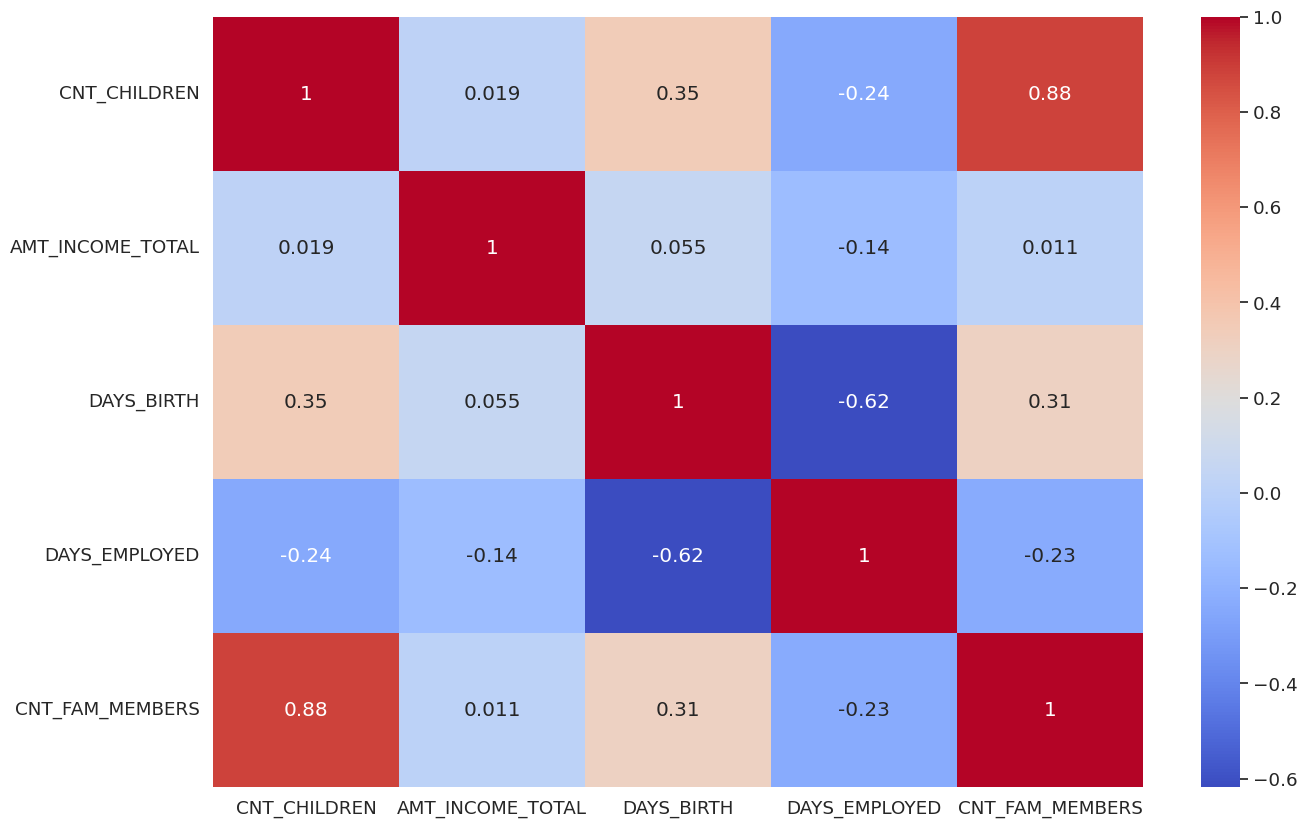

In [28]:
graficar_corr_num(caract_num)

#### Agrupación de características categóricas

In [29]:
caract_categ = X_train[lst_caract_categ]
caract_categ.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL
297872,F,N,Y,Commercial associate,Higher education,Married,House / apartment,1,0,0,0
24457,F,Y,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0
356993,F,Y,Y,Working,Secondary / secondary special,Married,House / apartment,1,0,1,0
356889,M,Y,N,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0
417768,M,Y,Y,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,0


In [30]:
def medir_ind_caract_vs_target(data, target):
    for columna in data.columns.values.tolist():
        tablaContingencia= pd.crosstab(data[columna], target)
        chi2, p, dof, ex = chi2_contingency(tablaContingencia.values)
        print(str(columna) + " - " + "target")
        print('Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p) + "\r\n")

#### Se identifican a las características relevantes

In [31]:
medir_ind_caract_vs_target(caract_categ, y_train)

CODE_GENDER - target
Chi-square Statistic 0.665 p_value 0.415

FLAG_OWN_CAR - target
Chi-square Statistic 0.082 p_value 0.775

FLAG_OWN_REALTY - target
Chi-square Statistic 0.416 p_value 0.519

NAME_INCOME_TYPE - target
Chi-square Statistic 3.288 p_value 0.511

NAME_EDUCATION_TYPE - target
Chi-square Statistic 2.465 p_value 0.651

NAME_FAMILY_STATUS - target
Chi-square Statistic 1.200 p_value 0.878

NAME_HOUSING_TYPE - target
Chi-square Statistic 10.897 p_value 0.053

FLAG_MOBIL - target
Chi-square Statistic 0.000 p_value 1.000

FLAG_WORK_PHONE - target
Chi-square Statistic 5.064 p_value 0.024

FLAG_PHONE - target
Chi-square Statistic 0.029 p_value 0.866

FLAG_EMAIL - target
Chi-square Statistic 0.591 p_value 0.442



#### Se eliminan las características redundantes o irrelevantes

In [32]:
caract_num_v1 = caract_num.drop(columns=['CNT_FAM_MEMBERS']).copy()
caract_categ_v1 = caract_categ.drop(columns=['FLAG_WORK_PHONE']).copy()

### Normalización de los valores de las características numéricas

In [33]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [34]:
scaler_v1 = MinMaxScaler()
columnas_v1 = caract_num_v1.columns
d_v1 = scaler_v1.fit_transform(caract_num_v1)
caract_num_train_nor_v1 = pd.DataFrame(d_v1, columns=columnas_v1)

caract_num_train_nor_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0.000000,0.036274,0.769930,0.040614
1,0.000000,0.032927,0.444388,0.043287
2,0.000000,0.012850,0.327744,0.042414
3,0.000000,0.029581,0.228376,1.000000
4,0.052632,0.032927,0.531165,0.043389


### Aplicación del One-hot Encoding sobre las características categóricas

In [35]:
encoder_v1 = OneHotEncoder(handle_unknown='ignore')
d_v1 = encoder_v1.fit_transform(caract_categ_v1)
caract_categ_train_ohe_v1 = pd.DataFrame(d_v1.toarray(), columns=encoder_v1.get_feature_names_out())

caract_categ_train_ohe_v1.head()

,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Formación del subset de entrenamiento preprocesado

In [36]:
X_train_v1 = pd.concat([caract_num_train_nor_v1, caract_categ_train_ohe_v1], axis = 1)
X_train_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,0.000000,0.036274,0.769930,0.040614,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.000000,0.032927,0.444388,0.043287,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.000000,0.012850,0.327744,0.042414,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.000000,0.029581,0.228376,1.000000,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.052632,0.032927,0.531165,0.043389,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Aplicación de SMOTE y RandomUnderSampler

In [37]:
!pip install imbalanced-learn

In [38]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [39]:
counter = Counter(y_train)
print(counter)

Counter({0: 329729, 1: 21046})


In [40]:
over = SMOTE(sampling_strategy=0.1, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_gen, y_train_gen = pipeline.fit_resample(X_train_v1, y_train)

In [41]:
counter = Counter(y_train_gen)
print(counter)

Counter({0: 65944, 1: 32972})


## Construcción de los modelos

In [42]:
!pip install xgboost

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
from xgboost import XGBClassifier

In [45]:
xgboost_hparams = {
    'max_depth': [5, 9, 15],
    'learning_rate': [0.01, 0.015, 0.025],
    'gamma': [0.3, 0.7, 1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'verbosity': [0]
}

In [46]:
# xgboost = XGBClassifier()
# xgboost_cv = GridSearchCV(xgboost, xgboost_hparams, scoring="f1", cv = 5, verbose=2)
# xgboost_cv.fit(X_train_gen, y_train_gen)

In [47]:
xgb_v1 = XGBClassifier().fit(X_train_gen, y_train_gen)

In [48]:
xgb_v1.score(X_train_gen, y_train_gen)

0.7698653402887299

## Fase de prueba de los modelos

In [49]:
X_test.drop(columns=columnas_eliminadas, inplace=True)
X_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
408630,M,Y,Y,0,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21639,365243,1,0,0,0,2.0
294597,M,Y,N,0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9115,-803,1,0,0,0,1.0
246234,F,N,N,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-19683,-4706,1,0,0,0,2.0
109406,F,Y,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-17392,-9219,1,0,0,0,2.0
127297,F,N,Y,2,103500.0,Commercial associate,Incomplete higher,Married,House / apartment,-9948,-2800,1,0,0,0,4.0


In [50]:
cols = X_test.isna().sum()
print(cols)

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
CNT_FAM_MEMBERS        0
dtype: int64


In [51]:
caract_num_test_v1 = X_test[caract_num_v1.columns.tolist()].copy()


In [52]:
for columna in caract_num_test_v1.columns.tolist():
    media_caract = medias_dict[columna]
    caract_num_test_v1[columna].replace(np.nan, media_caract, inplace=True)

In [53]:
caract_categ_test_v1 = X_test[caract_categ_v1.columns.tolist()].copy()

for columna in caract_categ_test_v1.columns.tolist():
    moda_caract = modas_dict[columna]
    caract_categ_test_v1[columna].replace(np.nan, moda_caract, inplace=True)

In [54]:
X_test = pd.concat([caract_num_test_v1, caract_categ_test_v1], axis = 1)
cols = X_test.isna().sum()
print(cols)

CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_PHONE             0
FLAG_EMAIL             0
dtype: int64


In [55]:
columnas_1 = caract_num_test_v1.columns
d_1 = scaler_v1.transform(caract_num_test_v1)
caract_num_test_nor_v1 = pd.DataFrame(d_1, columns=columnas_1)

caract_num_test_nor_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0.000000,0.022889,0.201107,1.000000
1,0.000000,0.016196,0.908198,0.043702
2,0.000000,0.019542,0.311540,0.033505
3,0.000000,0.022889,0.440888,0.021715
4,0.105263,0.011511,0.861168,0.038485


In [56]:
d_1 = encoder_v1.transform(caract_categ_test_v1)
caract_categ_test_ohe_v1 = pd.DataFrame(d_1.toarray(), columns=encoder_v1.get_feature_names_out())

caract_categ_test_ohe_v1.head()

,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [57]:
X_test_v1 = pd.concat([caract_num_test_nor_v1, caract_categ_test_ohe_v1], axis = 1)
X_test_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,0.000000,0.022889,0.201107,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.000000,0.016196,0.908198,0.043702,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.000000,0.019542,0.311540,0.033505,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.000000,0.022889,0.440888,0.021715,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.105263,0.011511,0.861168,0.038485,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [58]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [59]:
y_xgb_v1_pred = xgb_v1.predict(X_test_v1)

In [60]:
accuracy_score(y_test, y_xgb_v1_pred)

0.9244418090177207

In [61]:
f1_score(y_test, y_xgb_v1_pred)

0.0273047563123899

In [62]:
print(classification_report(y_test, y_xgb_v1_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     82432
           1       0.06      0.02      0.03      5262

    accuracy                           0.92     87694
   macro avg       0.50      0.50      0.49     87694
weighted avg       0.89      0.92      0.90     87694



In [150]:
y_probs = xgb_v1.predict_proba(X_test_v1)
print(y_probs[:,:-1])

[[0.71577835]
 [0.7118135 ]
 [0.70727324]
 ...
 [0.8086417 ]
 [0.81677115]
 [0.69390714]]


## Se exportan los recursos del modelo

In [69]:
from pickle import dump
import json

In [77]:
dump(scaler_v1, open('scaler.pkl', 'wb'))
dump(encoder_v1, open('encoder.pkl', 'wb'))
xgb_v1.save_model('xgb_v1.json')
dump(xgb_v1, open('model.pkl', 'wb'))
dump(caract_num_v1.columns.tolist(), open('ftr_nor.pkl', 'wb'))
dump(caract_categ_v1.columns.tolist(), open('ftr_cod.pkl', 'wb'))
with open("medias.json", "w") as outfile:
    json.dump(medias_dict, outfile)
with open("modas.json", "w") as outfile:
    json.dump(modas_dict, outfile)

## Se generan campos para dataset de prueba de carga

In [80]:
!pip install names

     |████████████████████████████████| 789 kB 6.6 MB/s eta 0:00:01
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803689 sha256=cd7abab9f243ce3577197b419a90f04b8997ed73d2cfe24ddcbe90876f1fbb4a
  Stored in directory: /home/g20160094/.cache/pip/wheels/d0/35/f7/c72132a4f3878b82018a3e61bf2a35e6b63cebe1dd9f72ec1e
Successfully built names
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [81]:
import random
import names

In [113]:
lst_phone_numbers_options = ['+51949972852', '+51990909561', '+51961615229']

In [129]:
lst_phone_numbers = []
lst_fullnames = []

for i in range(len(X_testing_webpage.index)):
    lst_fullnames.append(names.get_full_name())
    rand_idx = random.randrange(len(lst_phone_numbers_options))
    lst_phone_numbers.append(lst_phone_numbers_options[rand_idx])

In [130]:
df_clients_data = pd.DataFrame({'FULLNAME': lst_fullnames, 'PHONE_NUMBER': lst_phone_numbers})

In [131]:
df_clients_data.head()

,FULLNAME,PHONE_NUMBER
0,Rhonda Zediker,+51949972852
1,William James,+51961615229
2,Joel Rogoff,+51990909561
3,Darrell Hudson,+51961615229
4,Tracy Vandyke,+51961615229


In [132]:
X_testing_webpage = X_testing_webpage.reset_index()
X_testing_webpage = pd.concat([X_testing_webpage, df_clients_data], axis = 1)
X_testing_webpage.head()

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,FULLNAME,PHONE_NUMBER
0,282684,F,Y,N,0,351900.0,Pensioner,Higher education,Civil marriage,House / apartment,-22315,365243,1,0,1,0,NaN,2.0,Rhonda Zediker,+51949972852
1,124986,F,Y,Y,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-14692,-414,1,1,0,0,Cleaning staff,2.0,William James,+51961615229
2,380546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Married,House / apartment,-17335,-8688,1,1,1,1,Laborers,2.0,Joel Rogoff,+51990909561
3,393633,M,Y,Y,1,211500.0,Working,Secondary / secondary special,Married,House / apartment,-14883,-1093,1,0,0,0,Managers,3.0,Darrell Hudson,+51961615229
4,105601,M,N,Y,1,247500.0,Working,Higher education,Married,House / apartment,-11229,-2460,1,0,0,0,Drivers,3.0,Tracy Vandyke,+51961615229


In [134]:
X_testing_webpage.drop(columns=["index"]).to_csv('X_testing_webpage.csv', index=False)